In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import random
import collections
import re

# 8.1 Sequence Models

영화에 대한 평점을 내린다고 할 때 사람들의 생각은 시간이 지남에 따라 상당히 바뀔 수 있음. 

1. 다른 사람의 의견에 따르는 경향.  예를 들어, 오스카상을 받은 후에는 같은 영화라도 해당 영화에 대한 등급이 올라감. 

2. 좋은 영화를 많이 본 후에 다음 영화도 똑같이 좋거나 더 좋을 것이라는 기대가 높음. 훌륭한 영화를 많이 본 후에는 평범한 영화라도 나쁜 영화로 간주될 수 있음.

3. 계절성 - 8월에 산타클로스 영화를 보고 싶어하는 관객은 거의 없음.

4. 어떤 경우에는 제작 과정에서 감독이나 배우의 잘못된 행동으로 인해 영화가 인기를 끌지 못함.

요컨대, 영화 등급은 고정되어 있지 않고. 따라서 시간적 관계를 고려하여 사용하면 더 정확한 영화 추천이 가능




## 8.1.1 Statistical Tools

sequence data를 처리하려면, statistical tools 와 new deep neural network architectures 가 필요.

예) 간단한 주가(FTSE 100 지수) $t$시점에서의 가격 $x_t$를 예측

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$


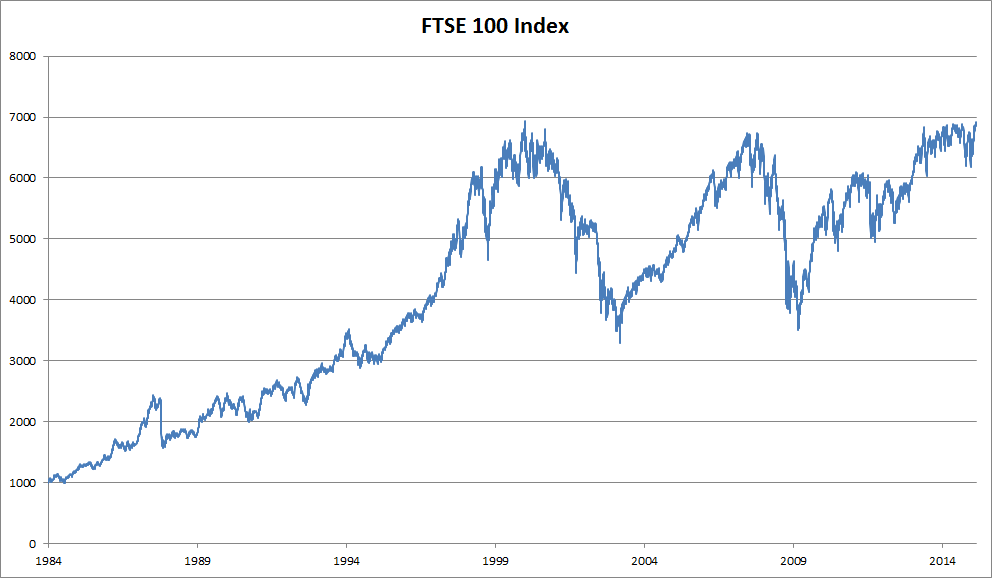

### 8.1.1.1. Autoregressive Models

이를 달성하기 위해, 섹션 3.3에서 훈련했던 것과 같은 regression 모델을 사용할 수 있음 

그러나 이 때 sequential 데이터를 다루기 힘든 이유는 우리가 얻고 싶은 것은 하나의 라벨일 때가 많은데,  sequentail data 정의상 길이가 언제 끝날지 모르기 때문이다. 즉 받아들여야 하는 차원을 알 수가 없다.

즉 t에 따라 input의 수,  $x_{t-1}, \ldots, x_1$ 이 다르다. 


이것을 계산적으로 다루기 쉽게 만들기 위해 근사치가 필요하다. 

이 섹션에서는 $P(x_t \mid x_{t-1}, \ldots, x_1)$ 를 효율적으로 추정하는 방법에 대해 두 가지 전략을 요약한다. 


1.  $x_{t-1}, \ldots, x_1$ 의 잠재적으로 긴 시퀀스가 실제로 필요하지 않다고 가정하여, $x_{t-1}, \ldots, x_{t-a}$ 과거의 모든 데이터를 보지 않고 과거의 일부만 고려한다. 
말 그대로 자체적으로 회귀를 수행하므로 autoregressive model 이라고 한다.




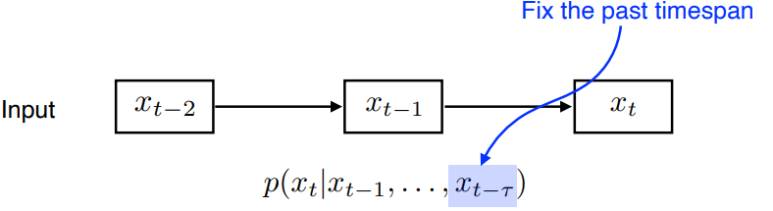

2. 중간에 hidden state가 있어서 과거의 정보를 요약하여 다음 타임 스텝에서 참고한다. 

이전 hidden state $h_{t-1}$와 그 가중치의 곱 + 이전 $x_{t-1}$ Input값과 그 가중치의 곱 = 현재 hidden state를 업데이트 

$h_t = g(h_{t-1}, x_{t-1})$.

다음 번 timestep은 이 hidden state 하나에만 dependent 하다고 볼 수 있다. 하나의 과거와 이전의 state가 아니라 이전의 정보를 요약하는 hidden state라고 보는 형태, 즉 과거 값들에 대한 회귀로 미래 값을 예측하는 방법 *latent autoregressive models*이라고 한다.



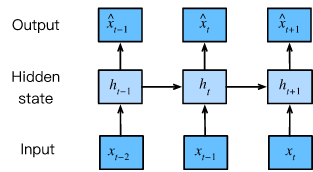

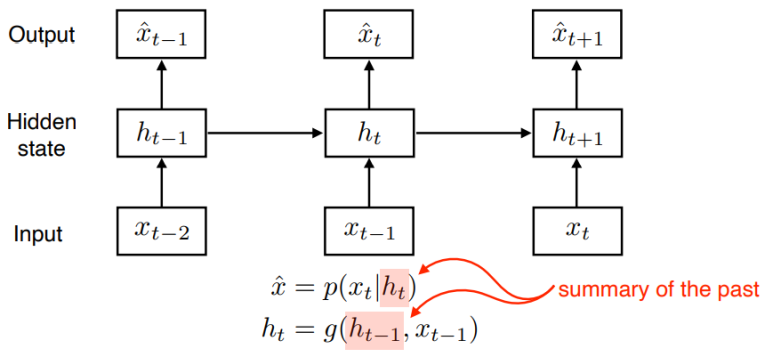

###8.1.1.2. Markov Models

first-order autoregressive model 이라고도 하는데
즉 현재는 바로 직전의 과거에만 dependent 하다고 가정하는 것이다.

이는 현실에서 말이 되지 않는데, 내일의 시험 점수는 전날 공부한 것에만 dependent하지 않으므로 이러한 형태의 모델은 많은 정보를 버릴 수밖에 없는 형태이다.


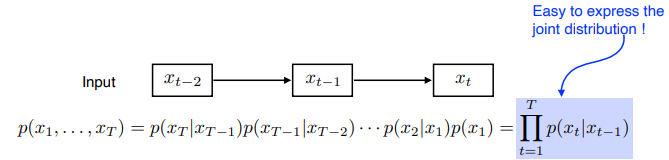

###8.1.1.3. Casuality

사실 마르코프 모델이 있다면 역 조건부 확률 분포도 얻을 수 있다. 

그러나 많은 경우 데이터는 시간의 방향에 따라 영향을 받으며, 미래의 사건들이 과거에 영향을 미칠 수 없다는 것이 분명하다. 

즉 $x_t$를 변경하면 앞으로 $x_{t + 1}$ 에 대해 일어나는 일에 영향을 줄 수 있지만 그 반대는 영향을 미치지 않는다. 즉, $x_t$를 변경하여도 과거 이벤트에 대한 분포가 변경되지 않는다. 



## 8.1.2. Training

이것들을 실제로 시험해 보기위해 몇 가지 데이터를 생성하는 것으로 시작. 

Time step 1,2, ...,1000에 대해 약간의 noise 가 있는 사인 함수를 사용하여 시퀀스 데이터를 생성.

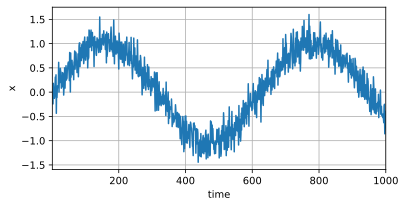

In [ ]:
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

모델이 훈련할 수 있는 특징과 레이블로 바꿔줌 

Embedding dimension $τ$ 을 기반으로 데이터를  $y_t = x_t$ and $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$ 쌍으로 매핑.

첫 번째 $\tau$ 에 대한 충분한 history를 가지고 있지 않기 때문에 제외한 996개 사용

처음 600개의 features-labels pair만 훈련에 사용.



In [ ]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [ ]:
print(features.shape)
print(len(labels))

torch.Size([996, 4])
996


2 FC layers , ReLU activation and squared loss MLP

In [ ]:
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# Note: `MSELoss` computes squared error without the 1/2 factor
loss = nn.MSELoss(reduction='none')

In [ ]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.115973
epoch 2, loss: 0.058161
epoch 3, loss: 0.051138
epoch 4, loss: 0.049976
epoch 5, loss: 0.050618


## 8.1.3. Prediction

Train loss가 작기 때문에, 모델이 잘 작동할 것으로 기대. 

이것은 모델이 다음 time step, 즉 1-step 앞선 예측에서 어떤 일이 일어나는지 얼마나 잘 예측할 수 있는지 예측 하는 것.

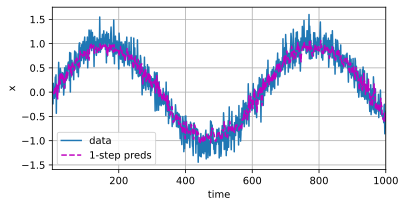

In [ ]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

예상했던 것처럼 1-step 앞서서 예측하는 것은 nice. 

604 (n_train + tau)을 넘어서도 예측은 여전히 신뢰할만함. 

그러나 1 step 씩 나아가기 때문에 time step 604까지만 시퀀스 데이터를 볼 수 있다면,

그 이후의 데이터는 input으로 받을 수 없다.

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

일반적으로 $x_t$까지 관측된 시퀀스의 경우에서 time step $t+k$에서 $x_{t+k}$를 예측하는 것을 k-step-ahead prediction이라고 한다. 

$x_{604}$까지 관측했으므로 k-step-ahead prediction은 다음과 같다. $x_{604+k}$. 


다시 말해, 우리는 multistep-ahead prediction 을 하기 위해 현재 prediction model을 사용해야 할 것이다. 이게 얼마나 잘 되는지 보자.

In [ ]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

In [ ]:
print(len(multistep_preds[: n_train + tau]))

604


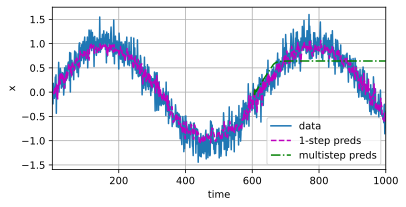

In [ ]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

이 때 예측은 몇번의 예측 단계 후에 꽤 빠르게 constant로 변한다. 알고리즘이 왜 그렇게 제대로 작동하지 않았을까? 이는 궁극적으로 오류가 누적된 데 따른 것.


1단계 이후에 약간의 오류가 발생한다고 가정. $\epsilon_1 = \bar\epsilon$.

이제 2단계에 대한 입력은  $\epsilon_1$, 에 의해 더욱 교란됨.

상수 $c$에 대해 $\epsilon_2 = \bar\epsilon + c \epsilon_1$. 

이번 장과 그 이 후에 이를 개선하기 위한 방법에 대해 논의할 것.


k = 1,4,16,64에 대한 전체 시퀀스에 대한 prediction을 계산하여 k-step-adhead prediction의 어려움에 대해 자세히 확인.


time steop t까지 관측된 시퀀스의 경우에서 time step t+k에서의 output prediction은 k단계 선행 예측이다. 오차가 누적되고 예측 품질이 크게 저하

In [ ]:
max_steps = 64

In [ ]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

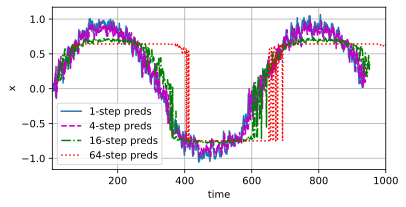

In [ ]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

# 8.2 Text Preprocessing

텍스트는 시퀀스 데이터의 가장 보편적 인 예 중 하나

1. 텍스트 데이터를 문자열로 메모리에 로드. 
2. 문자열을 토큰(예: 단어 및 문장)으로 분할. 
3. 분할된 토큰을 숫자 인덱스에 매핑할 vocabulary 표를 작성. 
4. 텍스트를 숫자 인덱스의 시퀀스로 변환하여 모델에 의해 쉽게 조작할 수 있음.

##8.2.1. Reading the Dataset

H. G. Wells *The Time Machine* data

3만 단어의 작은 corpus

데이터 세트를 텍스트 행 목록으로 읽고. 여기서 각 행은 문자열. 구두점과 대문자를 무시

In [ ]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## 8.2.2. Tokenization

다음 tokenize fuction은 텍스트 시퀀스(예: 텍스트 라인) list input으로 사용합니다. 

각 텍스트 시퀀스는 token list로 분할됩(토큰은 텍스트의 기본 단위)입니다. 마지막으로 각 라인이 토큰(문자열)들의 list로 반환.

In [ ]:
def tokenize(lines, token='word'): 
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## 8.2.3. Vocabulary


모델에서 사용하기 편하도록 0부터 시작하는 숫자 인덱스에 문자열 토큰을 매핑(vocabulary dictionary 구축) 
 
먼저 데이터의 모든 corpus의 토큰을 세고, 그 빈도에 따라 토큰에 숫자 인덱스를 할당 

빈도가 작은  토큰은 복잡성을 줄이기 위해 제거

말뭉치에 없거나 제거된 토큰은 알 수 없는 특별한 토큰 "<unk>"에 매핑됩니다. 

패딩을 위한 것을 "pad", 
시퀀스의 시작을 나타내는 것을 "bos", 
시퀀스의 끝을 나타내는 것을 "eos"로  

따로 토큰 목록을 선택적으로 만듬

In [ ]:
class Vocab:  
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens): 
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

우리는 타임머신 데이터 세트를 말뭉치로 사용하여 어휘를 구성한다. 그런 다음 처음 몇 개의 자주 사용하는 토큰을 인덱스로 인쇄합니다.

이제 각 텍스트 라인을 숫자 index list로 변환할 수 있습니다

In [ ]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [ ]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


## 8.2.4. Putting All Things Together

위의 함수를 사용하여 모든 것을 load_corpus_time_machine 함수로 패키지화하여 토큰 인덱스 목록인 corpus와 타임머신 corpus의 어휘인 vocab을 반환한다. 

(i) 마지막 섹션에서는 훈련을 단순화하기 위해 텍스트를 단어가 아닌 문자로 토큰화한다. 

(ii) 각 텍스트 줄이 반드시 문장이나 문단이 아니기 때문에 
corpus는 토큰 리스트가 아닌 단일 리스트

In [ ]:
def load_corpus_time_machine(max_tokens=-1): 
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

#8.3 Language Models and the Dataset

길이 T의 텍스트 시퀀스의 토큰이 $x_1, x_2, \ldots, x_T$. 라고 가정. 

그런 다음 텍스트 순서에서 $x_t$($1 \leq t \leq T$)를 t 단계의 관측치 또는 레이블로 간주

이러한 텍스트 시퀀스가 주어지면, 언어 모델의 목표는 시퀀스의 결합 확률을 추정

##8.3.1. Learning a Language Model


예를 들어, 4개의 단어를 포함하는 텍스트 시퀀스의 확률은 다음과 같음

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

$$P(\text{deep}, \text{learning}, \text{is}, \text{fun}) =  P(\text{deep}) P(\text{learning}  \mid  \text{deep}) P(\text{is}  \mid  \text{deep}, \text{learning}) P(\text{fun}  \mid  \text{deep}, \text{learning}, \text{is}).$$

여기서, 훈련 데이터 세트가 모든 위키백과 항목, 프로젝트 구텐베르그 및 웹에 게시된 모든 텍스트와 같은 대규모 텍스트 말뭉치라고 가정. 

단어의 확률은 훈련 데이터 세트에서 주어진 단어의 상대 단어 빈도로부터 계산. 


"Deep"이라는 단어로 시작하는 문장의 확률로 계산. 즉 "deep"의 모든 경우를 세고 그것을 corpus의 총 단어 수로 나누는 것. 

특히 빈번한 단어에 대해 잘 작동하지만 여기서는 "deep learning"의 발생 빈도는 매우 낮기 때문에 어려움. 

또한 세 단어 조합이나 그 이상의 조합일 경우 더욱 좋지 않음. 

즉 데이터 세트가 작거나, 단어의 조합이 매우 희귀하다면, 목표와 같은 경우를 단 하나도 찾지 못할 수도 있음.

만약 기존에 없는 새로운 단어가 입력된다면 이에 대한 확률이 0이기 때문에 모든 확률이 0이 되는 문제가 발생합니다. 따라서, 작은 상수를 더함으로써 이를 해결. 분모에는 중복을 제거한 모든 데이터의 수를 더해줌.


*Laplace smoothing*.

$n$ : the total number of words in the training set 

$m$ : the number of unique words.

$$\begin{aligned}
	\hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
	\hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
	\hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}$$

$\epsilon_{1}$ = 0 이면 smoothing이 적용되지 않고,
무한대에 가까워지면 $1/m$에 가까워짐.


그러나 빠르게 사용하기 힘듬. 

1. 모든 카운트를 저장해야함

2. 단어의 의미를 고려하지 않음. "cat" , "feline"

3. 긴 단어 시퀀스가 나오면 이것은 거의 새로운 것이 확실하므로 이전에 본 단어 시퀀스의 빈도를 단순히 계산하는 모델은 성능이 저하될 수밖에 없음.



##8.3.2. Markov Models and n-grams

$P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$. 

하나의 변수, 두 개의 변수, 세 개의 변수를 포함하는 확률 공식은 일반적으로 각각 유니그램, 바이그램, 트라이그램 모형이라고 함

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),-unigram \\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),-bigram \\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).- trigram  
\end{aligned}
$$

*unigram*, *bigram*, and *trigram* models, 


## 8.3.3. Natural Language Statistics

실제 데이터에서 어떻게 작동하는지 확인해보자.

In [ ]:
tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

주로 stop words 라 불리는 것들이지만 사용할 것.

10번째로 가장 많이 사용되는 단어는 가장 많이 사용되는 단어만큼 1/5 미만

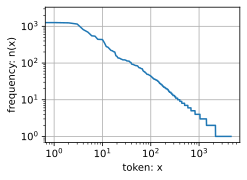

In [ ]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

Zipf’s law

영어 단어의 출현 빈도에 관한 성질을 나타내는 법칙. 단어를 출현 빈도가 높은 순으로 늘어 세워 순위 번호를 붙이면, 

‘순위 번호×출현 빈도=일정’이라는 관계가 성립한다는 경험 법칙

즉 빈도는 $\frac{1}{i^\alpha}$  에 비례합니다. 가장 많이 쓰이는 단어 $n_1$가 1번 쓰일 때 두 번째로 많이 쓰이는 단어$n_2$는 $\frac{1}{2^\alpha}$ 번 쓰임


$n_i$ of the $i^\mathrm{th}$ most frequent word

$$n_i \propto \frac{1}{i^\alpha},$$

$$\log n_i = -\alpha \log i + c,$$


In [ ]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

가장 빈번한 단어 쌍 10개 중 9개가 두 개의 stop words로 구성되어 있음, 1개만 "the time" 

In [ ]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

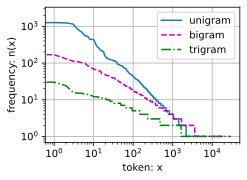

In [ ]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

첫째, 유니그램 단어 외에도 단어 시퀀스는 Zipf의 법칙을 따르는 것처럼 보임. 

둘째, 뚜렷한하게 많은 수의 n-gram은 그다지 많지 않다. 이것은 우리에게 언어에 꽤 많은 구조가 있다는 것을 보여줌. 

셋째, 많은 n-gram이 매우 드물게 발생하기 때문에 라플라스 스무딩은 언어 모델링에 적합하지 않음 


대신,딥 러닝 기반 모델을 사용할 것

##8.3.4. Reading Long Sequence Data

동일한 수의 타임 스텝을 가진 시퀀스로 긴 시퀀스를 분할

우리의 신경망을 훈련할 때, 그러한 시퀀스의 미니 배치가 모델에 공급

그림은 n=5 와 각 시간 단계의 토큰은 문자에 해당. 

초기 위치를 임의로 설정해서 coverage 와 randomness를 확보.



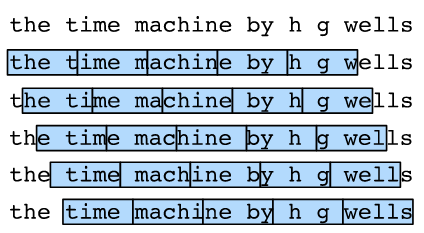

### 8.3.4.1. Random Sampling

iteration 동안 캡쳐된 인접한 두 개의 랜덤 미니 배치의 서브 시퀀스는 원본 시퀀스에서도 반드시 인접하지는 않음. 

레이블은 하나의 토큰만큼 이동된 시퀀스

다음 코드는 매번 데이터에서 미니 배치를 랜덤하게 생성. 

batch_size는 각 미니 배치의 서브 시퀀스 샘플 수를 지정
num_steps는 각 서브 시퀀스의 미리 정의된 time step 수.


In [ ]:
def seq_data_iter_random(corpus, batch_size, num_steps):  
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

sequence from 0 to 34. 

batch size 2

numbers of time steps 5

 $\lfloor (35 - 1) / 5 \rfloor= 6$ 개의 feature-labels 쌍을 만들 수 있음

따라서 미니배치 사이즈 크기가 2 이므로 총 3개의 미니배치 획득

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [ 2,  3,  4,  5,  6]])
X:  tensor([[21, 22, 23, 24, 25],
        [26, 27, 28, 29, 30]]) 
Y: tensor([[22, 23, 24, 25, 26],
        [27, 28, 29, 30, 31]])
X:  tensor([[11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [17, 18, 19, 20, 21]])


8.3.4.2. Sequential Partitioning

원래 시퀀스의 무작위 샘플링 외에도 반복하는 동안 두 개의 인접한 미니 배치의 시퀀스가 원래 시퀀스에 인접하도록 보장할 수 있다. 이 전략은 미니배치를 반복할 때 분할 시퀀스의 순서를 유지하므로 순차 분할이라고 합니다.


In [ ]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

동일한 설정을 사용하여 순차적 분할로 읽은 시퀀스의 각 미니 배치에 대해 피쳐 X와 레이블 Y를 인쇄합니다. 반복하는 동안 두 개의 인접한 미니 배치의 후속은 원래 시퀀스에서 실제로 인접합니다.

In [ ]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


두 sampling function을 class로 wrap

In [ ]:
class SeqDataLoader:  
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)       
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

data iterator and the vocabulary로드하는 함수 정의

In [ ]:
def load_data_time_machine(batch_size, num_steps, 
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

언어 모델은 자연어 처리의 핵심이다. 


n-그램은 의존성을 잘라냄으로써 긴 시퀀스를 처리하기 위한 편리한 모델을 제공한다. 

긴 시퀀스는 매우 드물거나 전혀 발생하지 않는다는 문제로 고통받는다. 

Zipf의 법칙은 유니그램뿐만 아니라 다른 n-그램에 대해서도 단어 분포를 지배한다. 

구조는 많지만 빈도가 부족하여 라플라스 평활을 통해 간헐적인 단어 조합을 효율적으로 처리할 수 없다. 

긴 시퀀스를 읽기 위한 주요 선택은 랜덤 샘플링과 순차 분할입니다. 
후자는 반복하는 동안 두 개의 인접한 미니배치로부터의 후속이 원래 시퀀스에 인접하도록 보장할 수 있다.


#8.4. Recurrent Neural Networks

##8.4.1 Neural Networks without Hidden States

활성화 함수 $\phi$

$\mathbf{X} \in \mathbb{R}^{n \times d}$ - batch size  𝑛 이고,  𝑑 개의 inputs인 mini batch

$\mathbf{H} \in \mathbb{R}^{n \times h}$ - hidden layer's output (아래와 같이 계산 됨)


$$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{xh} + \mathbf{b}_h).$$


 $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$ -weight parameter
 
 $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$ - the bias parameter 
 
$h$ -  number of hidden units for the hidden layer

𝐇 는 output layer의 input 으로 사용됨  

$$\mathbf{O} = \mathbf{H} \mathbf{W}_{hq} + \mathbf{b}_q,$$


$\mathbf{O} \in \mathbb{R}^{n \times q}$ - output variable

$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ - weight parameter of the output layer

$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ - bias parameter of the output layer.  

분류 문제라면 $\text{softmax}(\mathbf{O})$ 통해 최종 해결

##8.4.2  Recurrent Neural Networks with Hidden States

$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ - time step $t$에서의 mini batch, batch size(n),inputs(d)

$\mathbf{H}_t  \in \mathbb{R}^{n \times h}$ - time step $t$에서의 hidden variable

$\mathbf{H}_{t-1}$ - 이전 time step 에서의 hidden variable 

$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ - 이전 time step 의 hidden variable을 현재 time step에 사용하기 위해 나타낸 새로운 weight parameter.



*현재 time step의 hidden variable 계산은 이전 time step의 hidden variable 함께 현재 time step의 inputs에 의해 결정!!*


$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$

이렇게 추가된 hidden variable 을 hidden states라고 하며, 이전 스텝과 현재 스텝에서 같은 정의로 반복되어 계산되기 때문에 Recurrent Neural Network 라는 이름을 붙이게 됨.


$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$


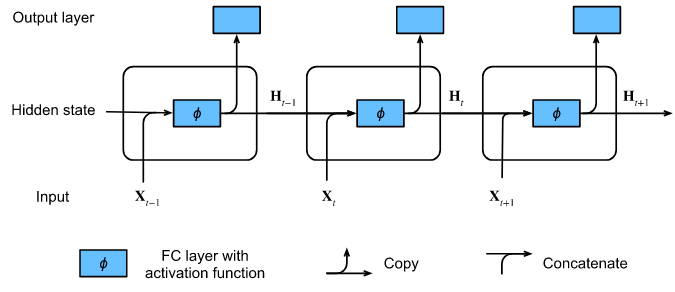

(i) 현재 time step t에서 입력 Xt와 이전 time step t-1에서 온 hidden state Ht-1을 연결 

(ii) output 계산을위해 연결 결과를 활성화 함수 $ϕ$ 를 적용하여 Fully-connected layer를 공급

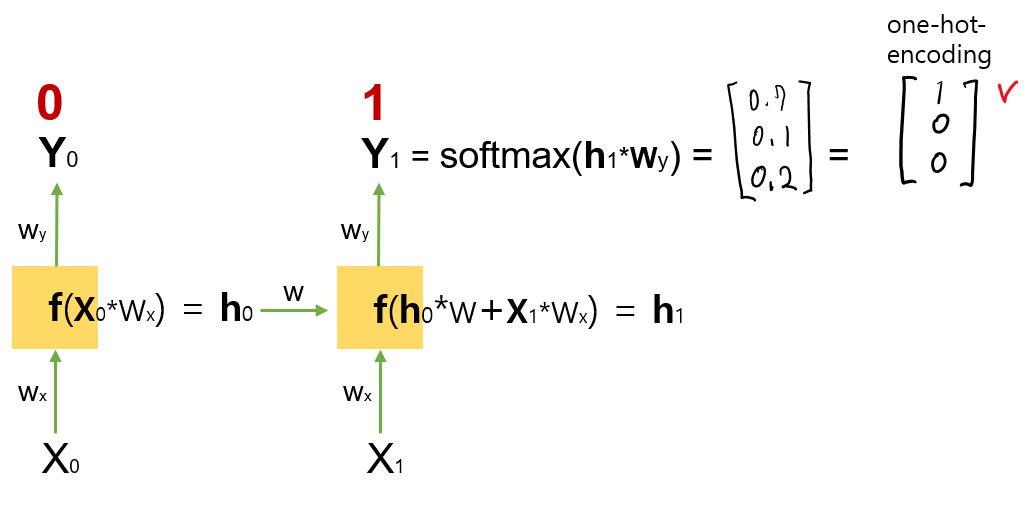

$\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}$ 를 보여주기 위해 

`X`, `W_xh`, `H`, `W_hh` 를 각각 

(3, 1), (1, 4), (3, 4), and (4, 4) 의 metrices로 정의해봄

열을 따라 X와 H 행렬을 연결. (3, 5)

행(축 0)을 따라 W_xh와 W_hh 행렬을 연결. (5, 4) 

두 행렬을 곱하면 아래 와 같은 모양의 출력 행렬 (3, 4)

In [ ]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

In [ ]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

##8.4.3. RNN-based Character-Level Language Models


language modeling 에서 현재 및 과거의 토큰을 기반으로 다음 토큰을 예측하는 것을 목표로 하므로 레이블로 원래 시퀀스를 한 토큰씩 이동하여 사용.

 이번에는 RNN을 사용하여 언어 모델을 구축하는 방법을 설명

 최소 배치 크기를 1로 하고 텍스트의 순서를 "machine"으로 설정

심플하게 하기 위해 단어가아닌 문자단위로 토큰화 (이전 알파벳으로 다음 알파벳 예측)

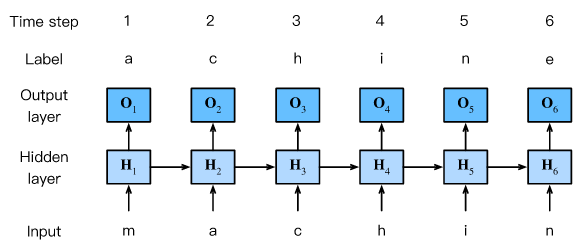

Figure 3번째 time step 단계의 출력 O3는 텍스트 시퀀스 {m}, {a} ,{c}에 의해 결정됨. 

데이터에서 시퀀스의 다음 문자는 {h}이므로, time steop 3의 loss는 이 시간 단계의 특징 시퀀스 {m}, {a}, {c} 및 레이블 {h}에 기초하여 생성된 다음 문자의 확률 분포로 나와 이를 통해 결과 도출

## 8.4.4. Perplexity

RNN 기반 언어 모델 품질을 측정하는 방법에 대해 논의


“It is raining outside”

“It is raining banana tree”

“It is raining piouw;kcj pwepoiut”

1번이 best

2번은 무의미, 하지만 알파벳 간의 상관관계는 어느정도 학습하여 단어 완성

3번은 제대로 학습되지 않은 모델(데이터에 적합하지 않음)


*perplexity(PPL)*

모델 내에서 자신의 성능을 수치화하여 결과를 내놓는 것을 말한다.

즉 이전 단어로 다음 단어를 예측할 때 몇 개의 단어 후보를 고려하는지를 의미.

고려해야 할 단어 후보가 많다는 것은 그 만큼 언어 모델이 쉽게 정답을 못 내고 있다고 해석할 수 있습니다. 즉, Perplexity 값이 낮을수록 언어 모델이 쉽게 정답을 찾아내는 것이므로 성능이 우수하다고 평가


단어의 개수가 N인 문장 W의 Perplexity(PPL)의 수식은 아래와 같음

$$PPL(W) = \sqrt[N]{\frac{1}{P(w_1, w_2, w_3, ...., w_N)}} = \sqrt[N]{\frac{1}{\displaystyle \prod_{i=1}^{N} P(w_i | w_1, w_2, w_3, ...., w_{i-1})}}$$

평균적으로 N의 단어 후보 중 정답을 찾는다고 해석할 수 있음

ex) 10 개 중에 찾는다면

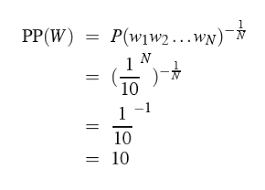